# 1.1 Movies Database

Take the movies dataset and turn it into a single `sqlite` database. It should have one table for each csv file in the movies dataset

In [24]:
import pandas as pd
import sqlite3
import matplotlib.pylab as plt 
import statsmodels.api as sm
import seaborn as sns


conn = sqlite3.connect('data\Movie_sqlite.db')
# Check available tables

c = conn.cursor()

pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", con=conn)


table_names = [
    'credits', 'keywords', 'links_small', 'links', 
    'movies_metadata', 'ratings_small', 'ratings',
]

#if the table does not exist remoove the coments 

'''
for e in table_names:
    print(f'data/Movies/{e}.csv')
    df=pd.read_csv(f'data/Movies/{e}.csv')
    df.to_sql(e, con=conn, index=False)
'''
print('The table already exists')


The table already exists


In [25]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", con=conn)



,name
0,credits
1,keywords
2,links_small
3,links
4,movies_metadata
5,ratings_small
6,ratings


# 1.2 Queries

**1.2.1** Use a single query to pull the original title of movies with a budget above $5m

**1.2.2** Use a query to pull the english-language films with the word `war` in their title

**1.2.3** Left join the average ratings from the `ratings` table onto the `movies_metadata` table, so you can have a relation between budget and rating. Hint: use a subquery.

In [26]:
pd.read_sql_query(
"""
SELECT
    original_title,
    budget
FROM 
    movies_metadata
WHERE 
    budget > 5e6
""", 
    con=conn
)

,original_title,budget
0,Jumanji,65000000
1,Heat,60000000
2,Sabrina,58000000
3,GoldenEye,58000000
4,The American President,62000000
...,...,...
2182,The Emoji Movie,50000000
2183,Pattaya,5402000
2184,House of the Long Shadows,7500000
2185,Все и сразу,750000


In [27]:
pd.read_sql_query(
"""
SELECT
    original_title
    
FROM 
    movies_metadata
WHERE 
    original_language=='en'
        ---Movies titles that ends withs war
    and  original_title  LIKE '% war'
        ---Movies titles that begings withs war
    or  original_title  LIKE 'war %'
    ---Movies titles with war in the middle
    or  original_title  LIKE '% war %'
 
""", 
    con=conn
)


,original_title
0,The War
1,The War Room
2,War Stories Our Mother Never Told Us
3,In Love and War
4,The War at Home
...,...
119,War Don Don
120,War for the Planet of the Apes
121,Underworld: Endless War
122,War Machine


In [28]:
pd.read_sql_query(
"""
SELECT
    original_title,
    budget
FROM 
    movies_metadata
WHERE 
    budget > 5e6
""", 
    con=conn
)

,original_title,budget
0,Jumanji,65000000
1,Heat,60000000
2,Sabrina,58000000
3,GoldenEye,58000000
4,The American President,62000000
...,...,...
2182,The Emoji Movie,50000000
2183,Pattaya,5402000
2184,House of the Long Shadows,7500000
2185,Все и сразу,750000


In [29]:
df = pd.read_sql(
"""
SELECT
    budget,
    id,
    mean_rating

FROM 
    movies_metadata

LEFT JOIN  
        (SELECT
            avg(rating) as mean_rating,
            movieId

        FROM 
            ratings

        GROUP BY 
            movieId ) as a
            
ON movies_metadata.id =a.movieId 
WHERE mean_rating IS NOT NULL

""", con=conn)

In [30]:
df=df.dropna()
df.budget=df.budget.astype(float)




X=df.budget
y=df.mean_rating

reg=sm.OLS(
        y,
        sm.add_constant(X.astype(float)),
        cov_type='HC2').fit()

display(reg.summary())
display(df.corr())
# No relation ? ...

#R^2 =0
#P value >0.1
#no corr


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mean_rating   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.499
Date:                Sun, 14 Feb 2021   Prob (F-statistic):              0.221
Time:                        17:39:20   Log-Likelihood:                -7130.5
No. Observations:                7569   AIC:                         1.426e+04
Df Residuals:                    7567   BIC:                         1.428e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1243      0.008    415.932      0.000       3.110       3.139
budget      3.535e-10   2.89e-10      1.224      0.221   -2.12e-10    9.19e-10
==============================================================================
Omnibus:                     1122.528   Durbin-Watson:                   1.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2049.482
Skew:                          -0.949   Prob(JB):                         0.00
Kurtosis:                       4.701   Cond. No.                     2.74e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

,budget,mean_rating
budget,1.000000,0.014073
mean_rating,0.014073,1.000000


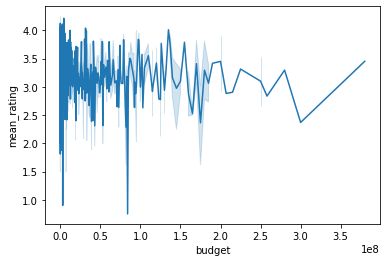

In [31]:
fig,ax1= plt.subplots()
sns.lineplot(data=df, x="budget", y="mean_rating",ax=ax1)
plt.show()

# No relation ? ...


# 2. Baseball Database

The [Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) has an sqlite version. Download it for these exercises.

**2.1** Which player has had the most homeruns?

**2.2** Is there a relation between how many homeruns a player has made in a year and his salary that year? Pull both colums together in a single query



In [32]:
conn = sqlite3.connect('data\lahmansbaseballdb.sqlite')
# Check available tables
a=pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", con=conn)
display(a)


,name
0,allstarfull
1,appearances
2,awardsmanagers
3,awardsplayers
4,awardssharemanagers
5,awardsshareplayers
6,batting
7,battingpost
8,collegeplaying
9,divisions


In [33]:
#2.1

# df with player ID, Full name  and Total homeruns

df_hr=pd.read_sql_query(
"""
SELECT
    people.playerID,
    nameFirst || ' ' ||  nameLast AS FullName,
    --- aLL I need is to put MAX(Tot_HR)
    Tot_HR
FROM 
    people
LEFT JOIN 
        (SELECT
           sum(HR) as Tot_HR,
           batting.playerID

        FROM 
            batting

        GROUP BY 
            playerID) as b

ON people.playerID=b.playerID

""",con=conn)

display(df_hr.head(5))
# if we do it with pandas ( cheat )
# The Sql verstion on next cell 

print(3*'\n', 'max HR')
df_hr.loc[df_hr.Tot_HR==df_hr.Tot_HR.max()]

,playerID,FullName,Tot_HR
0,aardsda01,David Aardsma,0.0
1,aaronha01,Hank Aaron,755.0
2,aaronto01,Tommie Aaron,13.0
3,aasedo01,Don Aase,0.0
4,abadan01,Andy Abad,0.0





 max HR


,playerID,FullName,Tot_HR
1632,bondsba01,Barry Bonds,762.0


In [34]:
pd.read_sql_query(
"""
SELECT
    salary,
    playerID,
    yearID
FROM 
    salaries
"""

,con=conn)

,salary,playerID,yearID
0,870000.0,barkele01,1985
1,550000.0,bedrost01,1985
2,545000.0,benedbr01,1985
3,633333.0,campri01,1985
4,625000.0,ceronri01,1985
...,...,...,...
26423,10400000.0,strasst01,2016
26424,524000.0,taylomi02,2016
26425,524900.0,treinbl01,2016
26426,21733615.0,werthja01,2016


In [35]:
df_s=pd.read_sql_query(
"""
 
SELECT
    HR as Tot_HR,
    batting.playerID,
    batting.yearID,
    salary

    FROM 
        batting

    INNER JOIN
        (SELECT
            salary,
            playerID,
            yearID
        FROM 
            salaries) as s

    ON  batting.playerID=s.playerID 
        and batting.yearID=s.yearID


    GROUP BY 
        batting.playerID,
        batting.yearID
    
""",con=conn)

display(df_s.head(10))

,Tot_HR,playerID,yearID,salary
0,0,aardsda01,2004,300000.0
1,0,aardsda01,2007,387500.0
2,0,aardsda01,2008,403250.0
3,0,aardsda01,2009,419000.0
4,0,aardsda01,2010,2750000.0
5,0,aardsda01,2012,500000.0
6,0,aasedo01,1986,600000.0
7,0,aasedo01,1987,625000.0
8,0,aasedo01,1988,675000.0
9,0,aasedo01,1989,400000.0


In [36]:
X=df_s.Tot_HR
y=df_s.salary

reg=sm.OLS(
        y,
        sm.add_constant(X),
        cov_type='HC2').fit()

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 salary   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     2257.
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        17:39:37   Log-Likelihood:            -4.1917e+05
No. Observations:               25500   AIC:                         8.383e+05
Df Residuals:                   25498   BIC:                         8.384e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.528e+06   2.42e+04     63.088      0.000    1.48e+06    1.58e+06
Tot_HR       1.14e+05   2399.470     47.504      0.000    1.09e+05    1.19e+05
==============================================================================
Omnibus:                    16276.861   Durbin-Watson:                   0.476
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           188212.912
Skew:                           2.977   Prob(JB):                         0.00
Kurtosis:                      14.904   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

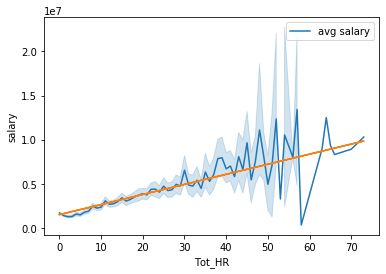

In [37]:

y_reg=reg.predict(sm.add_constant(X)) 



fig, ax = plt.subplots()
sns.lineplot(data=df_s, x="Tot_HR", y="salary",label="avg salary",ax=ax)
ax.plot(X,y_reg)

In [38]:
# for every additional HM they get 1.14e+05 (+-) 2399.470 dollars